In [1]:
library(rethinking)

Loading required package: rstan
Warning message:
"package 'rstan' was built under R version 3.3.2"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.3.2"Loading required package: StanHeaders
Warning message:
"package 'StanHeaders' was built under R version 3.3.2"rstan (Version 2.13.2, packaged: 2016-12-18 07:04:42 UTC, GitRev: 5fa1e80eb817)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
Loading required package: parallel
rethinking (Version 1.59)


In [2]:
data(tulips)

In [3]:
d<- tulips

In [6]:
d$bed.a <- ifelse( d$bed=="a" , 1 , 0 )
d$bed.b <- ifelse( d$bed=="b" , 1 , 0 )

In [8]:
d$shade.c <- d$shade - mean(d$shade)
d$water.c <- d$water - mean(d$water)

In [9]:
m7.9 <- map(
    alist(
        blooms ~ dnorm( mu , sigma ) ,
        mu <- a + bW*water.c + bS*shade.c + bWS*water.c*shade.c + ba*bed.a + bb*bed.b,
        a ~ dnorm( 130 , 100 ) ,
        bW ~ dnorm( 0 , 100 ) ,
        bS ~ dnorm( 0 , 100 ) ,
        bWS ~ dnorm( 0 , 100 ) ,
        ba ~ dnorm( 0 , 100 ) ,
        bb ~ dnorm( 0 , 100 ) ,
        sigma ~ dunif( 0 , 100 )
    ) ,
    data=d ,
    start=list(a=mean(d$blooms),bW=0,bS=0,bWS=0,ba=0,bb=0,sigma=sd(d$blooms)) )

In [10]:
m7.9


Maximum a posteriori (MAP) model fit

Formula:
blooms ~ dnorm(mu, sigma)
mu <- a + bW * water.c + bS * shade.c + bWS * water.c * shade.c + 
    ba * bed.a + bb * bed.b
a ~ dnorm(130, 100)
bW ~ dnorm(0, 100)
bS ~ dnorm(0, 100)
bWS ~ dnorm(0, 100)
ba ~ dnorm(0, 100)
bb ~ dnorm(0, 100)
sigma ~ dunif(0, 100)

MAP values:
         a         bW         bS        bWS         ba         bb      sigma 
146.068212  75.189996 -41.267070 -52.162067 -47.941011  -3.429834  39.185236 

Log-likelihood: -137.36 

In [13]:
m7.9a <- map(
    alist(
        blooms ~ dnorm( mu , sigma ) ,
        mu <- a + bW*water.c + bS*shade.c + bWS*water.c*shade.c ,
        a ~ dnorm( 130 , 100 ) ,
        bW ~ dnorm( 0 , 100 ) ,
        bS ~ dnorm( 0 , 100 ) ,
        bWS ~ dnorm( 0 , 100 ) ,
        sigma ~ dunif( 0 , 100 )
    ) ,
    data=d ,
    start=list(a=mean(d$blooms),bW=0,bS=0,bWS=0,sigma=sd(d$blooms)) )

In [15]:
compare(m7.9,m7.9a)

       WAIC pWAIC dWAIC weight    SE  dSE
m7.9  294.7   9.7   0.0   0.57  9.81   NA
m7.9a 295.3   6.3   0.6   0.43 10.44 8.14

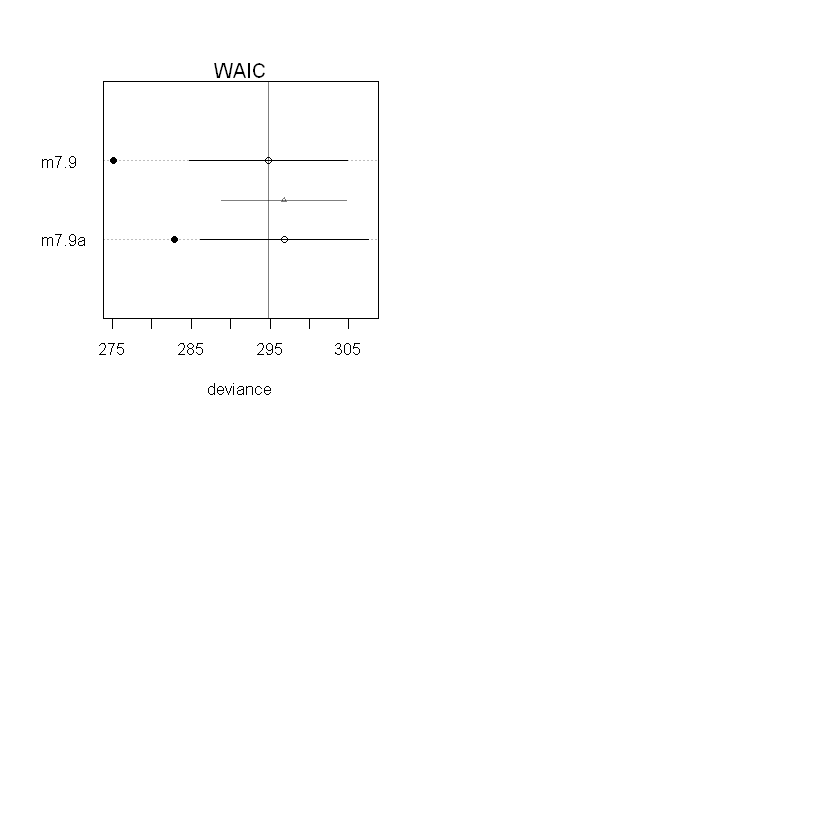

In [17]:
par(mfrow = c(2,2))
plot(compare(m7.9,m7.9a) )

In [18]:
post <- extract.samples( m7.9 )

In [40]:
coeftab(m7.9 )

      m7.9   
a      146.07
bW      75.19
bS     -41.27
bWS    -52.16
ba     -47.94
bb      -3.43
sigma   39.19
nobs       27

In [39]:
HPDI(post$ba, prob=c(.01,.5,.89) )
HPDI(post$bb, prob=c(.01,.5,.89) )

|0.89      |0.5     |0.01     0.01|      0.5|     0.89| 
-76.44872 -58.20172 -45.86513 -45.50436 -33.90456 -17.94830

|0.89       |0.5      |0.01      0.01|       0.5|      0.89| 
-33.622263 -16.062321  -2.292519  -1.952076   8.354597  23.636312

In [41]:
mean(post$ba)
mean(post$bb) #a lot of it is between less than 0 and above 0

[1] -47.92747

[1] -3.845642

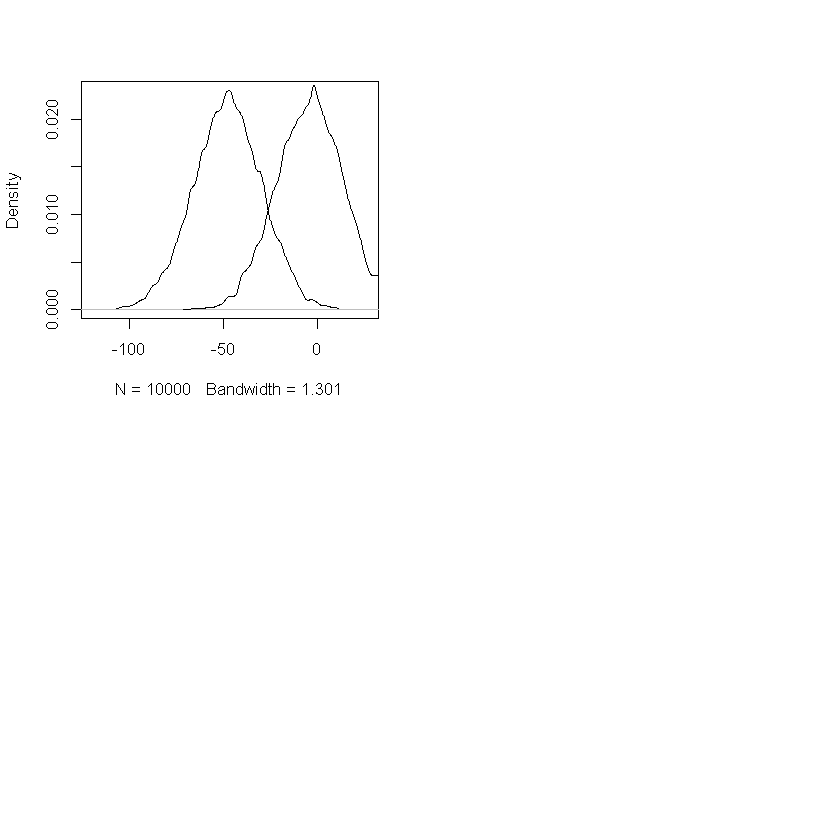

In [44]:
par(mfrow = c(2,2))
dens(post$ba)
dens(post$bb , add= TRUE)

In [45]:
data(rugged)
dd <- rugged

# extract countries with GDP data
dd <- dd[ complete.cases(dd$rgdppc_2000) , ]

# make log version of outcome
dd$log_gdp <- log( dd$rgdppc_2000 )

## R code 7.7
m7.5 <- map(
    alist(
        log_gdp ~ dnorm( mu , sigma ) ,
        mu <- a + gamma*rugged + bA*cont_africa ,
        #gamma linear interaction effect 
        #we are saying ruggedness depends on africa_condition and africa_condition depends on ruggednes
        gamma <- bR + bAR*cont_africa ,#gamma is the slope of ruggedness given continent of Africa
        a ~ dnorm( 8 , 100 ) ,
        bA ~ dnorm( 0 , 1 ) ,#continent of Africa coef
        bR ~ dnorm( 0 , 1 ) ,#Rugged coef
        bAR ~ dnorm( 0 , 1 ) ,#Rugged & Africa interaction coef
        sigma ~ dunif( 0 , 10 )
    ) ,
    data=dd )
WAIC(m7.5)
coeftab(m7.5)

Constructing posterior predictions


[ 1000 / 1000 ]


[1] 469.6802
attr(,"lppd")
[1] -229.4916
attr(,"pWAIC")
[1] 5.348447
attr(,"se")
[1] 15.17061

      m7.5   
a        9.18
bA      -1.85
bR      -0.18
bAR      0.35
sigma    0.93
nobs      170

In [ ]:
data(rugged)
dd <- rugged

# extract countries with GDP data
dd <- dd[ complete.cases(dd$rgdppc_2000) , ]

# make log version of outcome
dd$log_gdp <- log( dd$rgdppc_2000 )

## R code 7.7
m7.5 <- map(
    alist(
        log_gdp ~ dnorm( mu , sigma ) ,
        mu <- a + gamma*rugged + bA*cont_africa ,
        #gamma linear interaction effect 
        #we are saying ruggedness depends on africa_condition and africa_condition depends on ruggednes
        gamma <- bR + bAR*cont_africa ,#gamma is the slope of ruggedness given continent of Africa
        a ~ dnorm( 8 , 100 ) ,
        bA ~ dnorm( 0 , 1 ) ,#continent of Africa coef
        bR ~ dnorm( 0 , 1 ) ,#Rugged coef
        bAR ~ dnorm( 0 , 1 ) ,#Rugged & Africa interaction coef
        sigma ~ dunif( 0 , 10 )
    ) ,
    data=dd )
WAIC(m7.5)
coeftab(m7.5)

In [53]:
dd1 <-  dd[dd$country != 'Seychelles',]

## R code 7.7
m7.5b <- map(
    alist(
        log_gdp ~ dnorm( mu , sigma ) ,
        mu <- a + gamma*rugged + bA*cont_africa ,
        #gamma linear interaction effect 
        #we are saying ruggedness depends on africa_condition and africa_condition depends on ruggednes
        gamma <- bR + bAR*cont_africa ,#gamma is the slope of ruggedness given continent of Africa
        a ~ dnorm( 8 , 100 ) ,
        bA ~ dnorm( 0 , 1 ) ,#continent of Africa coef
        bR ~ dnorm( 0 , 1 ) ,#Rugged coef
        bAR ~ dnorm( 0 , 1 ) ,#Rugged & Africa interaction coef
        sigma ~ dunif( 0 , 10 )
    ) ,
    data=dd1 )
WAIC(m7.5b)
coeftab(m7.5b)

Constructing posterior predictions


[ 1000 / 1000 ]


[1] 463.5684
attr(,"lppd")
[1] -227.0627
attr(,"pWAIC")
[1] 4.721473
attr(,"se")
[1] 14.96498

      m7.5b  
a        9.19
bA      -1.78
bR      -0.19
bAR      0.25
sigma    0.93
nobs      169

In [56]:
compare(m7.5,m7.5b)

Warning message in compare(m7.5, m7.5b):
"Different numbers of observations found for at least two models.
Information criteria only valid for comparing models fit to exactly same observations.
Number of observations for each model:
m7.5 170 
m7.5b 169 
"Warning message in waic_ptw1 - waic_ptw2:
"longer object length is not a multiple of shorter object length"

       WAIC pWAIC dWAIC weight    SE  dSE
m7.5b 463.5   4.7   0.0   0.96 15.01   NA
m7.5  469.6   5.3   6.2   0.04 15.05 9.99

In [57]:
rugged.seq <- seq(from=-1,to=8,by=0.25)

mu.Africa <- link( m7.5 , data=data.frame(cont_africa=1,rugged=rugged.seq) )
mu.Africa.mean <- apply( mu.Africa , 2 , mean )
mu.Africa.PI <- apply( mu.Africa , 2 , PI , prob=0.97 )

mu.NotAfrica <- link( m7.5 , data=data.frame(cont_africa=0,rugged=rugged.seq) )
mu.NotAfrica.mean <- apply( mu.NotAfrica , 2 , mean )
mu.NotAfrica.PI <- apply( mu.NotAfrica , 2 , PI , prob=0.97 )


[ 1000 / 1000 ]
[ 1000 / 1000 ]


In [59]:
rugged.seq <- seq(from=-1,to=8,by=0.25)

mu.Africab <- link( m7.5b , data=data.frame(cont_africa=1,rugged=rugged.seq) )
mu.Africa.meanb <- apply( mu.Africab , 2 , mean )
mu.Africa.PIb <- apply( mu.Africab , 2 , PI , prob=0.97 )

mu.NotAfricab <- link( m7.5b , data=data.frame(cont_africa=0,rugged=rugged.seq) )
mu.NotAfrica.meanb <- apply( mu.NotAfricab , 2 , mean )
mu.NotAfrica.PIb <- apply( mu.NotAfricab , 2 , PI , prob=0.97 )


[ 1000 / 1000 ]
[ 1000 / 1000 ]


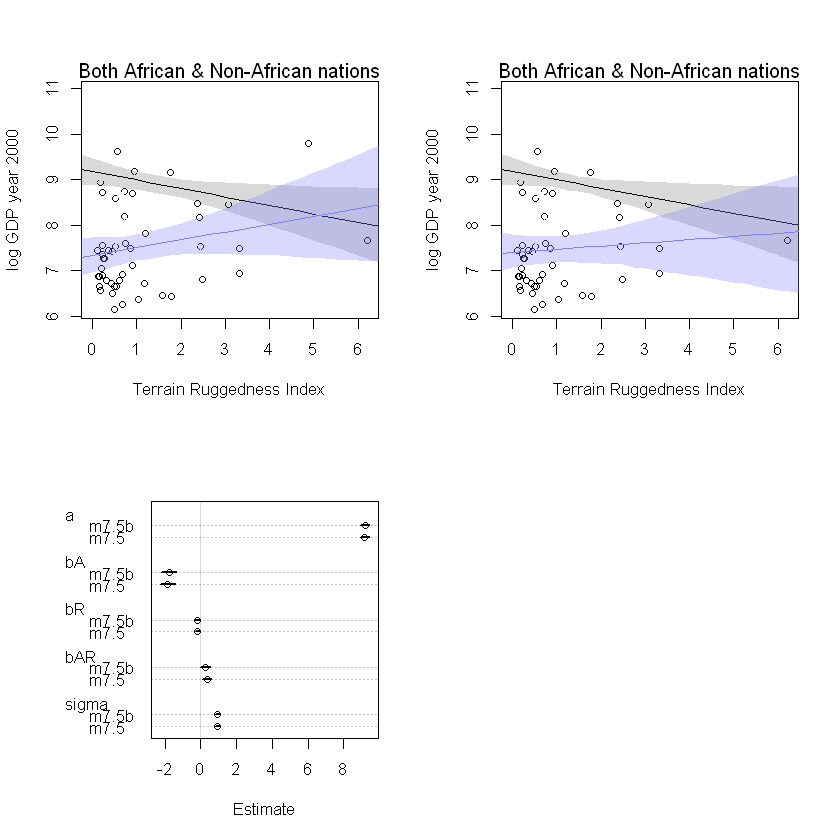

In [61]:
par(mfrow = c(2,2))
plot( log(rgdppc_2000) ~ rugged , data=dd ,
    col=dd$cont_africa , ylab="log GDP year 2000" ,
    xlab="Terrain Ruggedness Index" )
mtext( "Both African & Non-African nations" , 3 )
lines( rugged.seq , mu.NotAfrica.mean )
shade( mu.NotAfrica.PI , rugged.seq )
lines( rugged.seq , mu.Africa.mean , col=rangi2 )
shade( mu.Africa.PI , rugged.seq , col=col.alpha(rangi2,0.3) )

plot( log(rgdppc_2000) ~ rugged , data=dd1 ,
    col=dd1$cont_africa , ylab="log GDP year 2000" ,
    xlab="Terrain Ruggedness Index" )
mtext( "Both African & Non-African nations" , 3 )
lines( rugged.seq , mu.NotAfrica.meanb )
shade( mu.NotAfrica.PIb , rugged.seq )
lines( rugged.seq , mu.Africa.meanb , col=rangi2 )
shade( mu.Africa.PIb , rugged.seq , col=col.alpha(rangi2,0.3) )

plot(coeftab(m7.5,m7.5b))

In [ ]:
# c)

In [ ]:
#7H4